# Brain Tumor Detection

In [1]:
#@title ## Mount Your Google Drive & Map your Directory
#@markdown Please run this cell (`Ctrl+Enter` or `Shift+Enter`) and follow the steps printed bellow.
import os

from google.colab import drive
drive.mount('/content/gdrive')

# check Google Drive is mounted
if not os.path.isdir("/content/gdrive"):
  raise FileNotFoundError("Your Google Drive isn't mounted. Please run the above cell.")

assignment_dir = "/content/gdrive/MyDrive/workspace/BrainTumorDetection"  #@param{type:"string"}
assignment_dest = "/content/project"

# create symbolic link
!rm -f {assignment_dest}
!ln -s "{assignment_dir}" "{assignment_dest}"
print(f'Succesfully mapped (ln -s) "{assignment_dest}" -> "{assignment_dir}"')

# cd to linked dir
%cd -q {assignment_dest}
print(f'Succesfully changed directory (cd) to "{assignment_dest}"')

Mounted at /content/gdrive
Succesfully mapped (ln -s) "/content/project" -> "/content/gdrive/MyDrive/workspace/BrainTumorDetection"
Succesfully changed directory (cd) to "/content/project"


In [2]:
#@title ##Init

#@markdown Import required modules and observe your resources

# auto reload
%load_ext autoreload
%autoreload 2

# import
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import random
import os

from data import DataGenerator
from network import VGGNet
from train import train_epoch
from loss import accuracy

# Show resources
!nvidia-smi

Sat Jun 19 13:09:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Handle Data

Size of dataset:  2870
Choosing data # 877
Tumor type:  meningioma


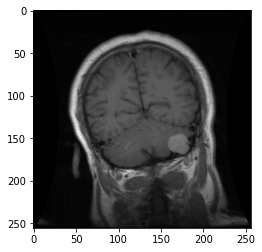

In [3]:
data_train_path = os.path.join(".", "Data", "Training")
data_test_path = os.path.join(".", "Data", "Testing")

data_train_gen = DataGenerator(data_train_path)

n = len(data_train_gen)
print("Size of dataset: ", n)

idx = random.randint(0, n)
print("Choosing data #", idx)

image, label = data_train_gen[idx]
print("Tumor type: ", data_train_gen.tumor_type2name[label])

plt.imshow(data_train_gen._vis_transforms(image))
plt.show()

### Network

In [4]:
net = VGGNet()
print("Network architecture: ", net)
out = net(image.unsqueeze(0))
print("Output size: ", out.shape)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



Network architecture:  VGGNet(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inp

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Output size:  torch.Size([1, 2])


### All together

In [ ]:
# params
data_train_path = os.path.join(".", "Data", "Training")
batch_size = 100
shuffle_data = True
lr = 0.001

# training setting
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VGGNet().to(device)
criterion = torch.nn.functional.cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loader = torch.utils.data.DataLoader(DataGenerator(data_train_path), 
                                     batch_size=batch_size, shuffle=shuffle_data)

# train
loss, acc = train_epoch(model=model, criterion=criterion, accuracy=accuracy, 
                        optimizer=optimizer, loader=loader, device=device)

In [ ]:
plt.figure()
plt.plot(loss)
plt.title("LOSS")
plt.figure()
plt.plot(acc)
plt.title("ACCURACY")
plt.show()